In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_curve, auc ,roc_auc_score
from sklearn.datasets import fetch_lfw_people # To fetch the Labeled Faces in the Wild (LFW) dataset
from sklearn.decomposition import PCA # For dimensionality reduction using Principal Component Analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Import TensorFlow for building and training deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential # Sequential model for building layer-by-layer
from tensorflow.keras.models import Model # Model for custom architectures
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time image augmentation during training
#import Neural network layers to train data       # Activation functions (e.g., ReLU, Sigmoid)                            # Regularization technique to prevent overfitting                                    
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D,MaxPooling2D, Flatten, Dropout, BatchNormalization # Normalizes activations to improve training speed and stability
                                        ## Fully connected (dense) layer   # pooling layer for spatial down-sampling
from tensorflow.keras.callbacks import LearningRateScheduler # Callback to dynamically adjust the learning rate during training
from tensorflow.keras.optimizers import SGD, RMSprop, Adam # Optimizers for training models

# Set random seed for reproducibility
# Random seeds help ensure that experiments are repeatable by initializing pseudorandom number generators in a consistent way
np.random.seed(42)
tf.random.set_seed(42)

In [62]:

# Load LFW (Labeled Faces in the Wild) dataset
                                 # min_faces_per_person=20: Filters the dataset to include only individuals who have at least 20 images to avoids classes with very few samples
data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=True, return_X_y=True)
#   - data_x: Image data (features) 4D array of shape
#   - data_y: Integar labels corresponding to each image (target classes) 1D array of shape

In [63]:

# Print the shape of the dataset (image data and labels)
print(f"Data shape: {data_x.shape}, Labels shape: {data_y.shape}")
# Analyze the class distribution in the dataset
unique_classes, counts = np.unique(data_y, return_counts=True)
# Print the number of unique classes and the number of samples per class, helps understand if the dataset is imbalanced.
print(f"Number of classes: {len(unique_classes)}, Samples per class: {counts}")


Data shape: (3023, 8742), Labels shape: (3023,)
Number of classes: 62, Samples per class: [ 39  35  21  36  20  77  42  24  29  21 236  31 121  22 530 109  44  26
  30  22  39  71  20  28  52  55  21  42  21  24  20  53  31  23  28  60
  32  41  22  41  48  29  33  20  22  37  20  22  30  27  32  26  23  52
  33  23  25  33 144  32  49  24]


In [64]:

# Default image size for LFW dataset
h, w = 62, 47  
# Reshape to include the channel dimension (RGB) , set 3 of pipe for covert 2D to 4D format for deep learning 
data_x = data_x.reshape(-1, h, w, 3)  #shape of data_x: (num_samples, height * width * channels) -1: Automatically infers the number of samples 
print(f"Reshaped data: {data_x.shape}") #Ensures the image data is now in a format compatible with deep learning frameworks like TensorFlow/Keras

Reshaped data: (3023, 62, 47, 3)


In [65]:
# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=42)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (2418, 62, 47, 3), Testing data shape: (605, 62, 47, 3)


In [66]:
# Normalize the data using the mean and standard deviation of the training set

# Compute the mean and standard deviation of the training data
# - axis=(0, 1, 2): Compute the mean and standard deviation across the height, width, and channel dimensions
mean = np.mean(X_train, axis=(0, 1, 2))#  This results in separate mean and std values for each color channel (RGB)
std = np.std(X_train, axis=(0, 1, 2))

X_train = (X_train - mean) / std
# Normalize the test data using the mean and std from the training setin order to avoid data leakage
X_test = (X_test - mean) / std

In [68]:
# Build a Convolutional Neural Network (CNN) model

# Initialize a Sequential model
model = Sequential()
# Input layer
model.add(Input(shape=(h, w, 3))) #shape=(h, w, 3): Input images are RGB with height `h` and width `w` (62x47 in this case)

# First convolutional block (Conv -> ReLU -> MaxPooling) 
# Conv2D(32, (3, 3)): Applies 32 filters of size 3x3 to extract features
model.add(Conv2D(32, (3, 3), activation='relu'))  #  ReLU activation
#Total Parameters=(Filter Height × Filter Width × Input Channels + Bias)×Number of Filters
model.add(MaxPooling2D((2, 2)))  # Max pooling layer to reduces spatial dimensions

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu')) # Increases filter depth to capture more complex features
model.add(MaxPooling2D((2, 2))) #Further reduces spatial dimensions

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output from convolutional layers to feed into the fully connected layer
model.add(Flatten())

# Fully connected layer with ReLU activation
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5)) #andomly drops 50% of neurons to reduce overfitting

# Output layer with softmax activation for multi-class classification
model.add(Dense(len(unique_classes), activation='softmax')) # softmax activation function to produce probabilities for each class

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary() # model architecture

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 60, 45, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,698,430 (6.48 MB)

 Trainable params: 1,698,430 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Learning rate scheduler function to reduce learning rate every 5 epochs
def lr_scheduler(epoch, lr):
    # Reduce the learning rate by 30% every 5 epochs to ensure smooth optimization.
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.7  # Multiplying by 0.7 reduces the step size, slowing down the weight updates.
    return lr

#Augmentation to improves the model’s generalization by introducing variations like rotations, translations, and flips.
datagen = ImageDataGenerator(
    rotation_range=20,          # Random rotations in the range of 0 to 20 degrees
    width_shift_range=0.1,      # Random horizontal shifts by up to 10% of the width
    height_shift_range=0.1,     # Random vertical shifts by up to 10% of the height
    shear_range=0.1,            # Random shearing transformations
    zoom_range=0.1,             # Random zoom in or out by 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest',        # Strategy for filling newly created pixels 
)
datagen.fit(X_train) #Prepares the data generator by calculating internal statistics

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64), # Use augmented data for training
    epochs=30, # Train 30 epochs
    validation_data=(X_test, y_test),   # Use test data for validation
    callbacks=[LearningRateScheduler(lr_scheduler)] #Use custom learning rate scheduler to adjust the learning rate dynamically during training.
)


Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1689 - loss: 3.8073 - val_accuracy: 0.1603 - val_loss: 3.6000 - learning_rate: 0.0010
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1848 - loss: 3.5850 - val_accuracy: 0.2099 - val_loss: 3.3465 - learning_rate: 0.0010
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.2194 - loss: 3.3689 - val_accuracy: 0.2645 - val_loss: 3.0456 - learning_rate: 0.0010
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2665 - loss: 3.0778 - val_accuracy: 0.3273 - val_loss: 2.7532 - learning_rate: 0.0010
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3218 - loss: 2.7818 - val_accuracy: 0.3702 - val_loss: 2.4689 - learning_rate: 0.0010
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3701 - loss: 2.5181 - val_accuracy: 0.4198 - val_loss: 2.2633 - learning_rate: 7.0000e-04
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4090 - loss: 2.3435 - val_accuracy: 

In [73]:
## save trained model to local, it will save at the same path
model.save('face_recognition_model.keras')

In [75]:
# Evaluate the model on the test data by loss and accuracy and print 
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7934 - loss: 0.8079
Test Accuracy: 79.34%


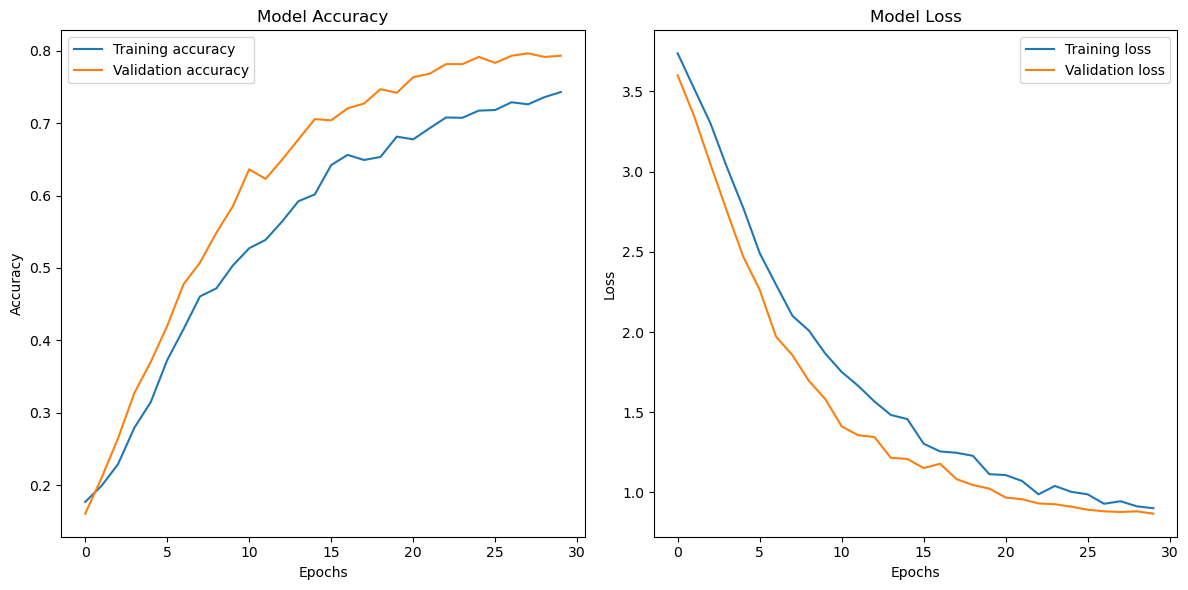

In [77]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

# Display the plots
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


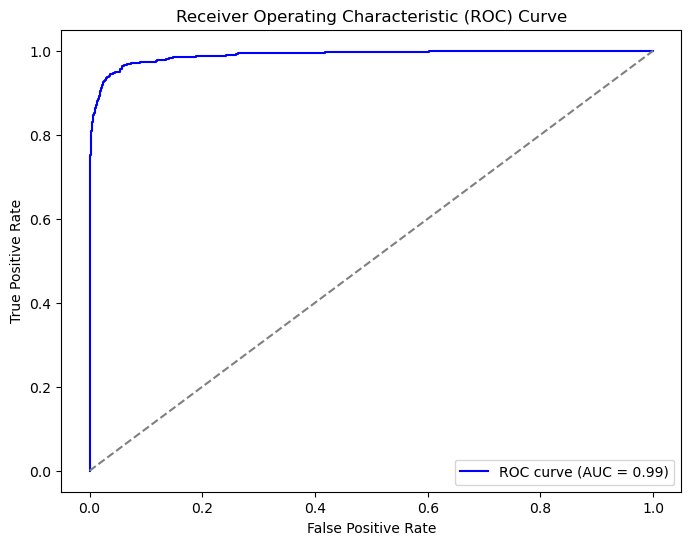

In [78]:
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=unique_classes)
y_pred_bin = model.predict(X_test)

# Calculate ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# ROC curve 

In the coordinate system, the vertical axis represents TPR (True Positive Rate/Hit Rate/Recall), with a maximum value of 1, and the horizontal axis represents FPR (False Positive Rate), also with a maximum value of 1. The dashed line serves as the baseline (minimum standard), and the blue curve is the ROC curve. The farther the ROC curve is from the baseline, the better the model's predictive performance.

## ROC curve close to the top left corner: 
The model trained has very high predictive accuracy.
## The AUC (Area Under Curve):
indicates the model’s overall ability to discriminate between classes. 
A value of 1 indicates perfect classification, this model AUC is 0.99 which mean the model perform well
